# Joint analysis of paired and unpaired multiomic data with MultiVI

MultiVI is used for the joint analysis of scRNA and scATAC-seq datasets that were jointly profiled (multiomic / paired) and single-modality datasets (only scRNA or only scATAC). MultiVI uses the paired data as an anchor to align and merge the latent spaces learned from each individual modality.

This tutorial walks through how to read multiomic data, create a joint object with paired and unpaired data, set-up and train a MultiVI model, visualize the resulting latent space, and run differential analyses.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi_colab/_core.py:42: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import ContextualVersionConflict
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile

import muon
import numpy as np
import requests
import scanpy as sc
import scvi
import seaborn as sns
import torch

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/muon/_core/preproc.py:31: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  if Version(scanpy.__version__) < Version("1.10"):


In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.4.2


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

## Data acquisition

First we download a sample multiome dataset from 10X, which we have preprocessed in a way similar to what is demonstrated in the scvi-tools [preprocessing tutorial](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/use_cases/preprocessing.html#multiome) (Note: the exact dataset was not used in the preprocessing tutorial). We'll use this throughout this tutorial.
Importantly, MultiVI assumes that there are shared features between the datasets. This is trivial for gene expression datasets, which generally use the same set of genes as features. For ATAC-seq peaks, this is less trivial, and often requires preprocessing steps with other tools to get all datasets to use a shared set of peaks. That can be achieved with tools like SnapATAC, ArchR, and CellRanger in the case of 10X data.

```{important}
MultiVI requires the datasets to use shared features. scATAC-seq datasets need to be processed to use a shared set of peaks.
```

```{note}
The original 10X dataset has been modified to remove some modality specific data such that 1/3 of the cells contain just gene expression data, 1/3 contain both gene expression and peaks data, and the remaining 1/3 of cells contain just peaks. The modification was done in order to demonstrate MultiVI's ability to mix multimodal and single-modal data. The dataset has 12012 cells total
```

Below we download the already preprocessed dataset.

In [5]:
# download preprocessed dataset
mdata_path = os.path.join(save_dir.name, "pbmc_10k_preprocessed.h5mu")

# direct download URL
url = "https://exampledata.scverse.org/scvi-tools/pbmc_10k_preprocessed.h5mu"

# Download only if file doesn't already exist
if not os.path.exists(mdata_path):
    print(f"Downloading MuData file to {mdata_path}...")
    r = requests.get(url)
    with open(mdata_path, "wb") as f:
        f.write(r.content)

# Load the MuData object
mdata = muon.read_h5mu(mdata_path)

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/mudata/_core/mudata.py:1403: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/mudata/_core/mudata.py:1275: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [6]:
# alternatively load the local preprocessed multivi data
# mdata_path = "scvi-tutorials/use_cases/pbmc_multi_preprocessed.h5mu" #preprocessed file
# Load the MuData object
# mdata = muon.read_h5mu(mdata_path)

```{important}
MultiVI requires the features to be ordered so that genes appear before genomic regions. This must be enforced by the user.
```

## Setup and Training MultiVI

We can now set up and train the MultiVI model!

First, we need to setup the Anndata object using the `setup_mudata` function. At this point we specify any batch annotation that the model would account for.
**Importantly**, the main batch annotation, specific by `batch_key`, should correspond to the modality of the cells.

Other batch annotations (e.g if there are multiple ATAC batches) should be provided using the `categorical_covariate_keys`.

The actual values of categorical covariates (include `batch_key`) are not important, as long as they are different for different samples.
I.e it is not important to call the expression-only samples "expression", as long as they are called something different than the multi-modal and accessibility-only samples.

```{important}
MultiVI requires the main batch annotation to correspond to the modality of the samples. Other batch annotation, such as in the case of multiple RNA-only batches, can be specified using `categorical_covariate_keys`.
```

In [7]:
mdata

MuData object with n_obs × n_vars = 12012 × 8000
  var:	'gene_ids', 'feature_types', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
  2 modalities
    rna_subset:	12012 x 4000
      var:	'gene_ids', 'feature_types', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'hvg'
    atac_subset:	12012 x 4000
      var:	'gene_ids', 'feature_types', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'hvg'

In [8]:
scvi.model.MULTIVI.setup_mudata(
    mdata,
    modalities={
        "rna_layer": "rna_subset",
        "atac_layer": "atac_subset",
    },
)

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


When creating the object, we need to specify how many of the features are genes, and how many are genomic regions. This is so MultiVI can determine the exact architecture for each modality.

In [9]:
model = scvi.model.MULTIVI(
    mdata,
    n_genes=len(mdata.mod["rna_subset"].var),
    n_regions=len(mdata.mod["atac_subset"].var),
)

model.view_anndata_setup()

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/torch/nn/modules/linear.py:124: UserWarning: Initializing zero-element tensors is a no-op
  init.kaiming_uniform_(self.weight, a=math.sqrt(5))


Anndata setup with scvi-tools version 1.4.2.

Setup via `MULTIVI.setup_anndata` with arguments:

{
│   'rna_layer': None,
│   'atac_layer': None,
│   'protein_layer': None,
│   'batch_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None,
│   'idx_layer': None,
│   'modalities': {'rna_layer': 'rna_subset', 'atac_layer': 'atac_subset'}
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│          n_atac          │ 4000  │
│         n_batch          │   1   │
│         n_cells          │ 12012 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│      n_size_factor       │   0   │
│          n_vars          │ 4000  │
└──────────────────────────┴───────┘

                Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location     ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │ adata.mod['rna_subset'].X  │
│     atac     │ adata.mod['atac_subset'].X │
│    batch     │  adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']    │
│    labels    │ adata.obs['_scvi_labels']  │
└──────────────┴────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [10]:
# For our sparse matrices, we want CSR rather than CSC as training will be faster
# We convert here since our downloaded dataset uses CSC (might not be the case for other datasets)
mdata.mod["rna_subset"].X = mdata.mod["rna_subset"].X.tocsr()
mdata.mod["atac_subset"].X = mdata.mod["atac_subset"].X.tocsr()
mdata.update()

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/mudata/_core/mudata.py:1403: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/mudata/_core/mudata.py:1275: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [11]:
model.train()

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi/model/_multivi.py:332: UserWarning: Disabling adversarial classifier.
  training_plan = self._training_plan_cls(self.module, **plan_kwargs)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 928.200. Signaling Trainer to stop.


## Save and Load MultiVI models

Saving and loading models is similar to all other scvi-tools models, and is very straight forward:

In [12]:
model_dir = os.path.join(save_dir.name, "multivi_pbmc10k")

model.save(model_dir, overwrite=True)

In [13]:
model = scvi.model.MULTIVI.load(model_dir, adata=mdata)

INFO     File /tmp/tmp9mgvti4b/multivi_pbmc10k/model.pt already downloaded                                         


/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/torch/nn/modules/linear.py:124: UserWarning: Initializing zero-element tensors is a no-op
  init.kaiming_uniform_(self.weight, a=math.sqrt(5))


In [14]:
mdata = model.adata

In [15]:
model = scvi.model.MULTIVI.load(model_dir, adata=mdata)

INFO     File /tmp/tmp9mgvti4b/multivi_pbmc10k/model.pt already downloaded                                         


/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/torch/nn/modules/linear.py:124: UserWarning: Initializing zero-element tensors is a no-op
  init.kaiming_uniform_(self.weight, a=math.sqrt(5))


In [16]:
mdata

MuData object with n_obs × n_vars = 12012 × 8000
  obs:	'_indices', '_scvi_batch', '_scvi_labels'
  var:	'gene_ids', 'feature_types', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
  uns:	'_scvi_uuid', '_scvi_manager_uuid'
  2 modalities
    rna_subset:	12012 x 4000
      var:	'gene_ids', 'feature_types', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'hvg'
    atac_subset:	12012 x 4000
      var:	'gene_ids', 'feature_types', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'hvg'

## Extracting and visualizing the latent space

We can now use the `get_latent_representation` to get the latent space from the trained model, and visualize it using scanpy functions:

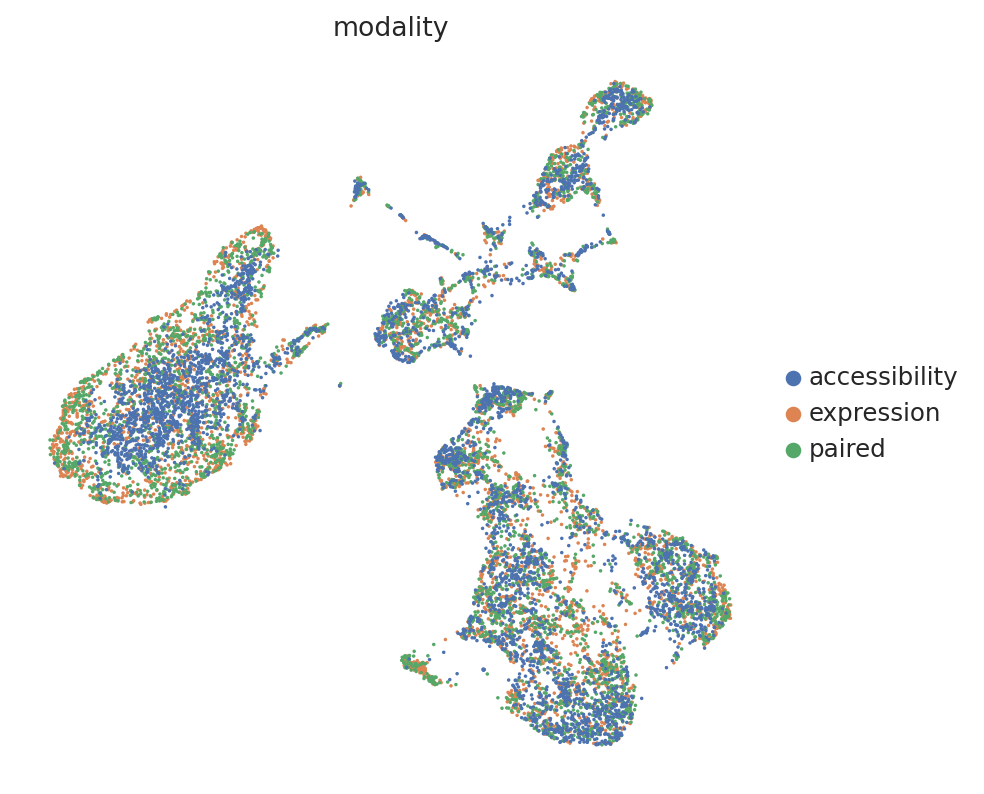

In [17]:
# Below we an cell annotations for modality, so we can color the UMAP

MULTIVI_LATENT_KEY = "X_multivi"

mdata.obsm[MULTIVI_LATENT_KEY] = model.get_latent_representation()
sc.pp.neighbors(mdata, use_rep=MULTIVI_LATENT_KEY)
sc.tl.umap(mdata, min_dist=0.2)

n = mdata.n_obs // 3

# initialize the column first
mdata.obs["modality"] = ""

# set modality of first third to rna
mdata.obs.iloc[:n, mdata.obs.columns.get_loc("modality")] = "expression"

# set modality of second third to both
mdata.obs.iloc[n : 2 * n, mdata.obs.columns.get_loc("modality")] = "paired"

# set modality of last third to atac
mdata.obs.iloc[2 * n :, mdata.obs.columns.get_loc("modality")] = "accessibility"

sc.pl.umap(mdata, color="modality")

## Impute missing modalities

In a well-mixed space, MultiVI can seamlessly impute the missing modalities for single-modality cells.
First, imputing expression and accessibility is done with `get_normalized_expression` and `get_normalized_accessibility`, respectively.

We'll demonstrate this by imputing gene expression for all cells in the dataset (including those that are ATAC-only cells):

In [18]:
imputed_expression = model.get_normalized_expression()
imputed_expression

,PLEKHN1,HES4,ISG15,TNFRSF18,TNFRSF4,TAS1R3,ANKRD65,PRDM16,SMIM1,AJAP1,...,SRPK3,SSR4,RPL10,CLIC2,LINC00278,PRKY,UTY,TTTY14,EIF1AY,AC233755.2
AAACAGCCAAAGCCTC-1,0.000004,0.000037,0.000257,0.000026,0.000019,0.000021,4.565451e-07,5.153532e-06,2.119693e-04,0.000021,...,0.000015,0.000325,0.003451,0.000025,0.000303,0.000439,0.000096,0.000439,1.274186e-04,0.000265
AAACAGCCAGAATGAC-1,0.000042,0.000042,0.000159,0.000012,0.000034,0.000006,6.844069e-06,8.621490e-06,7.530045e-07,0.000016,...,0.000006,0.000154,0.000853,0.000023,0.000019,0.000015,0.000049,0.000015,2.645564e-07,0.000781
AAACAGCCAGCTACGT-1,0.000039,0.000085,0.000264,0.000015,0.000017,0.000004,5.993893e-06,1.877613e-06,1.239749e-06,0.000028,...,0.000005,0.000073,0.000477,0.000010,0.000031,0.000018,0.000031,0.000018,8.254264e-07,0.000344
AAACAGCCAGGCCTTG-1,0.000036,0.000047,0.000183,0.000010,0.000040,0.000008,9.036130e-06,1.582899e-05,8.445228e-07,0.000017,...,0.000011,0.000277,0.001183,0.000045,0.000015,0.000025,0.000060,0.000020,4.929263e-07,0.001530
AAACAGCCATAAGGAC-1,0.000005,0.000083,0.001118,0.000024,0.000037,0.000014,5.805857e-07,5.824605e-06,3.471511e-05,0.000035,...,0.000031,0.000879,0.005431,0.000042,0.000115,0.000153,0.000064,0.000133,2.144945e-05,0.002195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTACGCGCA-1,0.000040,0.000028,0.000366,0.000079,0.000046,0.000011,1.792963e-06,7.886364e-07,1.476542e-04,0.000019,...,0.000014,0.000441,0.003157,0.000028,0.000287,0.000332,0.000110,0.000114,5.840710e-05,0.000135
TTTGTTGGTATTTGCC-1,0.000043,0.000062,0.000320,0.000013,0.000017,0.000003,3.492604e-06,3.161630e-06,8.942366e-07,0.000024,...,0.000005,0.000109,0.000718,0.000014,0.000030,0.000018,0.000040,0.000018,4.851468e-07,0.000398
TTTGTTGGTGATTACG-1,0.000030,0.000032,0.000309,0.000040,0.000020,0.000015,1.215865e-06,2.491740e-06,2.164369e-04,0.000020,...,0.000018,0.000364,0.002725,0.000032,0.000373,0.000505,0.000105,0.000198,9.393666e-05,0.000124
TTTGTTGGTTTCAGGA-1,0.000003,0.000042,0.000292,0.000024,0.000016,0.000021,3.641954e-07,5.929970e-06,2.222303e-04,0.000023,...,0.000018,0.000284,0.002743,0.000029,0.000325,0.000532,0.000097,0.000511,1.546627e-04,0.000207


In [19]:
imputed_accesssibility = model.get_normalized_accessibility()
imputed_accesssibility

,chr1:633579-634475,chr1:1098926-1099916,chr1:1143891-1144761,chr1:1216752-1217590,chr1:1371321-1371887,chr1:1629782-1630675,chr1:2049872-2050768,chr1:2152741-2153614,chr1:2304855-2305732,chr1:2839941-2840870,...,chrY:56869583-56870368,chrY:56870647-56871468,KI270728.1:232268-233167,KI270728.1:1791274-1791981,GL000194.1:21209-22162,GL000194.1:58250-58981,GL000205.2:67740-68619,GL000219.1:143461-144312,GL000218.1:44651-45083,GL000218.1:53403-54268
AAACAGCCAAAGCCTC-1,0.670868,0.666129,0.552354,0.030868,0.775174,0.997089,0.962572,0.250324,0.044848,0.751474,...,0.000233,0.003439,0.010708,0.005457,0.013041,0.008176,0.010336,0.002797,0.003115,0.000620
AAACAGCCAGAATGAC-1,0.616948,0.009348,0.037143,0.025052,0.220876,0.277224,0.095759,0.025231,0.089102,0.027598,...,0.008960,0.011620,0.001184,0.017608,0.003334,0.006596,0.049276,0.006662,0.002998,0.005135
AAACAGCCAGCTACGT-1,0.455226,0.008066,0.025428,0.015125,0.080354,0.188414,0.065048,0.022697,0.034986,0.013212,...,0.001641,0.009568,0.001929,0.004167,0.002980,0.008292,0.034392,0.011237,0.001166,0.002986
AAACAGCCAGGCCTTG-1,0.718132,0.010724,0.104629,0.025620,0.420016,0.282596,0.142242,0.040278,0.134599,0.049916,...,0.039936,0.011561,0.001600,0.033253,0.005033,0.006484,0.125697,0.005505,0.013359,0.006312
AAACAGCCATAAGGAC-1,0.711362,0.423509,0.243871,0.019735,0.631204,0.956851,0.796269,0.167036,0.031620,0.578852,...,0.000574,0.002462,0.028609,0.007174,0.015781,0.006427,0.022096,0.002286,0.002525,0.000386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTACGCGCA-1,0.669383,0.449880,0.529989,0.140976,0.637943,0.987469,0.975232,0.178848,0.025335,0.673543,...,0.000623,0.007630,0.003399,0.004860,0.005442,0.015022,0.009648,0.004133,0.001813,0.001691
TTTGTTGGTATTTGCC-1,0.448695,0.005883,0.020006,0.011801,0.089556,0.157725,0.051312,0.022979,0.027768,0.009855,...,0.001192,0.006607,0.001400,0.003732,0.001934,0.008029,0.041475,0.007944,0.000699,0.002397
TTTGTTGGTGATTACG-1,0.622925,0.562815,0.553203,0.050581,0.668126,0.989302,0.953819,0.249994,0.027520,0.704755,...,0.000317,0.005983,0.005864,0.005082,0.008057,0.012649,0.008363,0.003462,0.002475,0.001419
TTTGTTGGTTTCAGGA-1,0.638217,0.676973,0.564039,0.028386,0.794675,0.995742,0.937174,0.279246,0.043369,0.743070,...,0.000258,0.004589,0.015788,0.008083,0.014432,0.009162,0.011767,0.003396,0.004914,0.000697


In [20]:
model.differential_accessibility(groupby="modality", group1="accessibility").sort_values("prob_da")

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,prob_da,is_da_fdr,bayes_factor,effect_size,emp_effect,est_prob1,est_prob2,emp_prob1,emp_prob2
chr20:29124775-29125699,0.0786,False,-2.461522,-1.532413e-09,-0.000250,3.287984e-08,3.134743e-08,0.000250,0.000000
chr1:16644267-16645178,0.2614,False,-1.038705,2.315581e-03,-0.276973,9.229557e-01,9.252713e-01,0.559940,0.282967
chr12:123972581-123973483,0.2742,False,-0.973417,-2.247274e-03,-0.233267,8.189922e-01,8.167449e-01,0.474026,0.240759
chr20:50730818-50731721,0.3022,False,-0.836843,3.101230e-03,-0.253122,8.243484e-01,8.274497e-01,0.501998,0.248876
chr14:22556140-22556919,0.3146,False,-0.778701,3.993511e-04,-0.179446,6.960298e-01,6.964292e-01,0.372627,0.193182
...,...,...,...,...,...,...,...,...,...
chr5:148844412-148845290,0.5296,False,0.118539,1.414642e-03,-0.014860,9.964854e-02,1.010632e-01,0.030470,0.015609
chr2:128273300-128274158,0.5296,False,0.118539,-2.758071e-03,-0.009491,7.296444e-02,7.020637e-02,0.021229,0.011738
chr16:82451992-82452860,0.5302,False,0.120947,7.671099e-04,-0.004121,2.409380e-02,2.486091e-02,0.007992,0.003871
chr12:128388381-128389254,0.5342,False,0.137014,-1.368809e-03,-0.006369,5.156980e-02,5.020100e-02,0.014735,0.008367


We can demonstrate this on some known marker genes:

First, T-cell marker CD3.

In [21]:
mdata.mod["rna_subset"].var.index

Index(['PLEKHN1', 'HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'TAS1R3', 'ANKRD65',
       'PRDM16', 'SMIM1', 'AJAP1',
       ...
       'SRPK3', 'SSR4', 'RPL10', 'CLIC2', 'LINC00278', 'PRKY', 'UTY', 'TTTY14',
       'EIF1AY', 'AC233755.2'],
      dtype='object', length=4000)

In [22]:
np.where(mdata.mod["rna_subset"].var.index == "CD3G")

(array([2489]),)

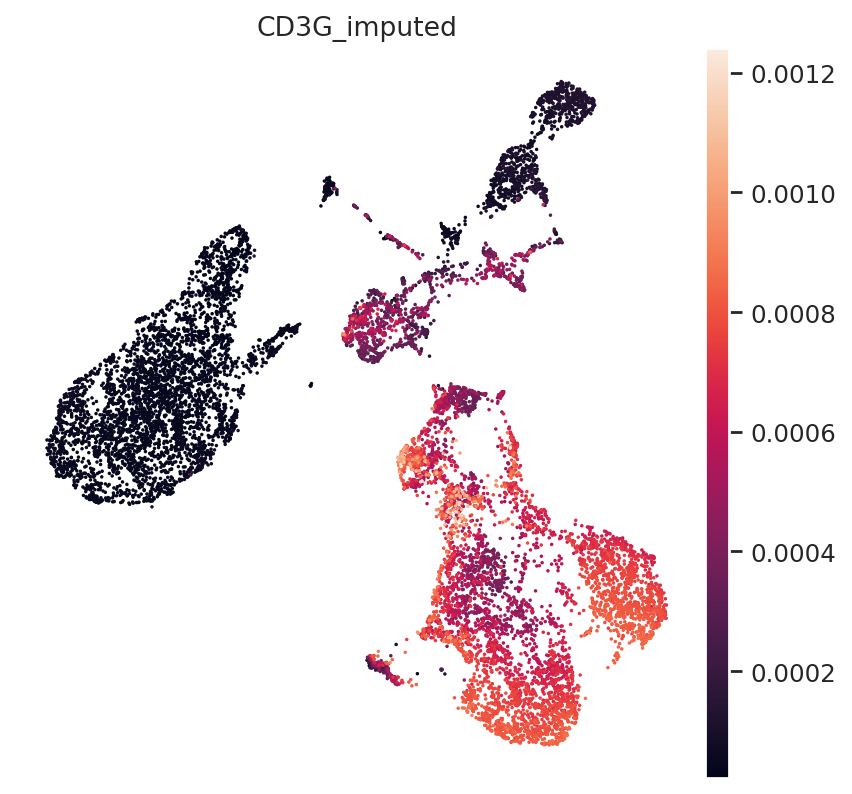

In [23]:
gene_idx = np.where(mdata.mod["rna_subset"].var.index == "CD3G")[0]
mdata.obs["CD3G_imputed"] = imputed_expression.iloc[:, gene_idx]
sc.pl.umap(mdata, color="CD3G_imputed")

Next, NK-Cell marker gene NCAM1 (CD56):

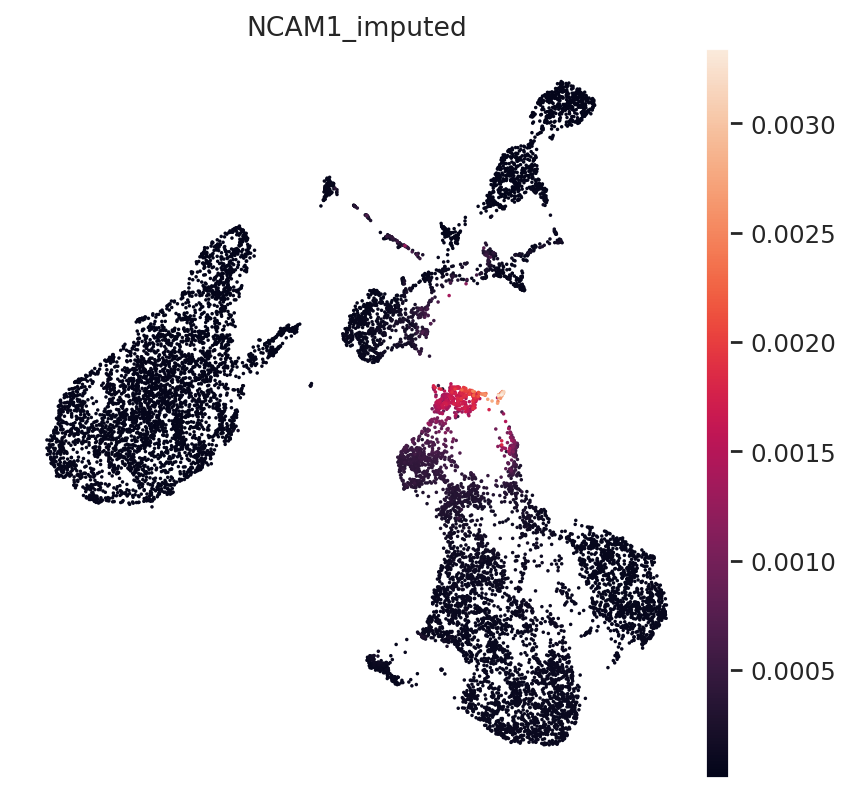

In [24]:
gene_idx = np.where(mdata.var.index == "NCAM1")[0]
mdata.obs["NCAM1_imputed"] = imputed_expression.iloc[:, gene_idx]
sc.pl.umap(mdata, color="NCAM1_imputed")

Finally, B-Cell Marker MS4A1:

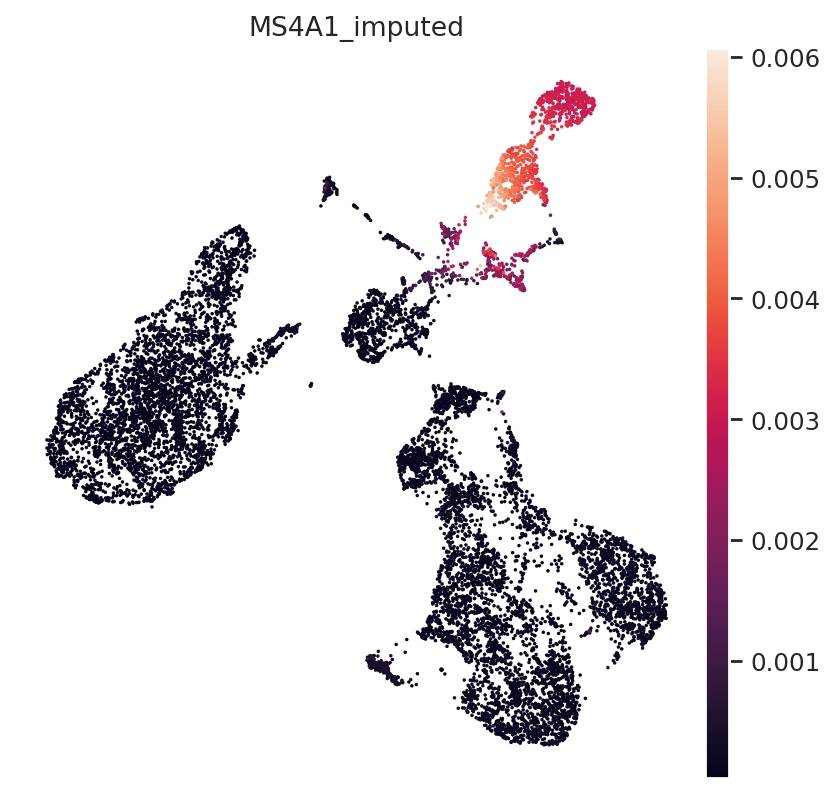

In [25]:
gene_idx = np.where(mdata.var.index == "MS4A1")[0]
mdata.obs["MS4A1_imputed"] = imputed_expression.iloc[:, gene_idx]
sc.pl.umap(mdata, color="MS4A1_imputed")

All three marker genes clearly identify their respective populations. Importantly, the imputed gene expression profiles are stable and consistent within that population, **even though many of those cells only measured the ATAC profile of those cells**.

Finaly lets see the most lowly expressed region as was found in the DE above:

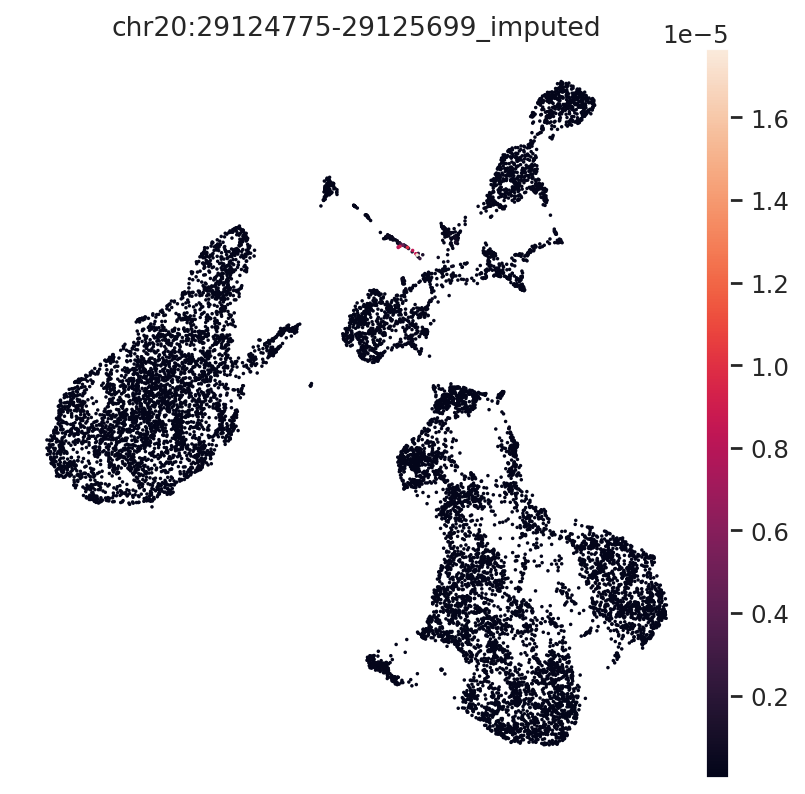

In [26]:
region_idx = np.where(mdata.var.index == "chr20:29124775-29125699")[0] - 4000
mdata.obs["chr20:29124775-29125699_imputed"] = imputed_accesssibility.iloc[:, region_idx]
sc.pl.umap(mdata, color="chr20:29124775-29125699_imputed")